<a href="https://colab.research.google.com/github/SarkisyanSergey/NLP_Pipiline/blob/main/NLP_PIPELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# установим  пакеты
!pip install pysrt
!pip install spacy

In [2]:
# импортируем библиотеки
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,
                                     StratifiedShuffleSplit,
                                     GridSearchCV
                                     )
from sklearn.pipeline import (Pipeline,
                              FeatureUnion
                              )

from sklearn.metrics import (classification_report,
                             f1_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay
                             )
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import (TfidfVectorizer,
                                             CountVectorizer
                                             )
from sklearn.base import (BaseEstimator,
                          TransformerMixin
                          )
import pysrt
import spacy
import nltk
from nltk.corpus import stopwords

import requests
import urllib
import json
import zipfile
from zipfile import ZipFile

In [3]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Трансформер для выбора одного столбца для выполнения
    дополнительных преобразований.
    Использование в текстовых столбцах
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]


class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Трансформер для выбора одного столбца для выполнения
    дополнительных преобразований.
    Использование в числовых столбцах
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

##Загрузка данных

###Загружаем данные по фильмам

In [4]:
#Импортируем файлы с Google Диска в Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PATH = '/content/drive/My Drive/Colab Notebooks/datasets'
path_to_zip_file = f'{PATH}/English_scores.zip'
path_to_zip_file

'/content/drive/My Drive/Colab Notebooks/datasets/English_scores.zip'

In [6]:
with ZipFile(path_to_zip_file, 'r') as zObject:
  znm = zObject.namelist()
print(znm)

['Subtitles_all/', '__MACOSX/._Subtitles_all', 'Subtitles_all/.DS_Store', '__MACOSX/Subtitles_all/._.DS_Store', 'Subtitles_all/B2/', '__MACOSX/Subtitles_all/._B2', 'Subtitles_all/A2/', '__MACOSX/Subtitles_all/._A2', 'Subtitles_all/C1/', '__MACOSX/Subtitles_all/._C1', 'Subtitles_all/B1/', '__MACOSX/Subtitles_all/._B1', 'Subtitles_all/Subtitles/', '__MACOSX/Subtitles_all/._Subtitles', 'Subtitles_all/B2/Crown, The S01E01 - Wolferton Splash.en.srt', '__MACOSX/Subtitles_all/B2/._Crown, The S01E01 - Wolferton Splash.en.srt', 'Subtitles_all/B2/Suits.Episode 1- Denial.srt', '__MACOSX/Subtitles_all/B2/._Suits.Episode 1- Denial.srt', 'Subtitles_all/B2/Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.HEVC.Crazy4ad.srt', '__MACOSX/Subtitles_all/B2/._Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.HEVC.Crazy4ad.srt', 'Subtitles_all/B2/Suits.S02E08.HDTV.x264-EVOLVE.srt', '__MACOSX/Subtitles_all/B2/._Suits.S02E08.HDTV.x264-EVOLVE.srt', 'Subtitles_all/B2/Virgin.River.S01E07.INTERNAL.720p.WEB.x264-STRiFE.srt'

In [7]:
with ZipFile(path_to_zip_file, 'r') as zObject:
  movies_labels = zObject.extract('movies_labels.xlsx')

In [8]:
#загружаем данные по фильмам
df = pd.read_excel(movies_labels, index_col='id')
df.head(3)

,Movie,Level
id,,
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2


In [9]:
# определим какие целевые метки содержат данные
df['Level'].unique()

array(['B1', 'B2', 'A2/A2+', 'C1', 'B1, B2', 'A2/A2+, B1', 'A2'],
      dtype=object)

In [10]:
# определим словарь меток с кодированием значений
label_dict = {'A2': 1,
              'A2/A2+': 1,
              'B1': 2,
              'A2/A2+, B1': 2,
              'B2': 3,
              'B1, B2': 3,
              'C1': 4}
# заменим метки числовыми значениями
df['Level'] = df['Level'].replace(label_dict)

In [11]:
# удалим дубликаты
df = df.drop_duplicates()
df.shape

(238, 2)

###Загрузка субтитров

In [12]:
films_name = {}
for srt in znm:
  if srt.find('.srt') != -1 and srt.find('__MACOSX') == -1:
    films_name[srt.split('/')[-1]] = srt
print(len(films_name))

278


In [13]:
# проверим для скольких фильмов, имеющих метку из таблицы, предоставлены субтитры
films_filtr = set(films_name.keys()) & set(df['Movie'] + '.srt')
len(films_filtr)

229

In [14]:
def load_subs(film):
  """загружет субтитры"""
  fsrt = f'{film}.srt'
  if fsrt not in set(films_name.keys()):
    return None
  with ZipFile(path_to_zip_file, 'r') as zObject:
    f = zObject.extract(films_name[fsrt])
    try:
      subs = pysrt.open(f)
    except:
      subs = pysrt.open(f,encoding='iso-8859-1')
  return subs

In [15]:
%%time
#загружаем субтитры
df['subs'] = df['Movie'].apply(load_subs)

CPU times: user 11 s, sys: 315 ms, total: 11.3 s
Wall time: 18.2 s


In [16]:
df['subs']

id
0      [1\n00:00:55,279 --> 00:01:07,279\n<font color...
1      [1\n00:01:54,281 --> 00:01:55,698\nHey!\n, 2\n...
2      [1\n00:00:15,089 --> 00:00:21,229\nResync: Xen...
3      [1\n00:00:17,610 --> 00:00:22,610\n- <i><font ...
4      [1\n00:00:27,240 --> 00:00:30,879\n<i>Oh, I co...
                             ...                        
236                                                 None
237                                                 None
238                                                 None
239                                                 None
240                                                 None
Name: subs, Length: 238, dtype: object

In [17]:
#удаляем пропуски
df = df.dropna().reset_index(drop=True)

In [18]:
df

,Movie,Level,subs
0,10_Cloverfield_lane(2016),2,"[1\n00:00:55,279 --> 00:01:07,279\n<font color..."
1,10_things_I_hate_about_you(1999),2,"[1\n00:01:54,281 --> 00:01:55,698\nHey!\n, 2\n..."
2,A_knights_tale(2001),3,"[1\n00:00:15,089 --> 00:00:21,229\nResync: Xen..."
3,A_star_is_born(2018),3,"[1\n00:00:17,610 --> 00:00:22,610\n- <i><font ..."
4,Aladdin(1992),1,"[1\n00:00:27,240 --> 00:00:30,879\n<i>Oh, I co..."
...,...,...,...
225,Suits.S03E06.720p.HDTV.x264-mSD,4,"[1\n00:00:01,383 --> 00:00:02,751\nI lost Ava ..."
226,Suits.S03E07.HDTV.x264-mSD,4,"[1\n00:00:00,052 --> 00:00:01,352\nPreviously ..."
227,Suits.S03E08.480p.HDTV.x264-mSD,4,"[1\n00:00:01,436 --> 00:00:03,028\nI get Ava H..."
228,Suits.S03E09.480p.HDTV.x264-mSD,4,"[1\n00:00:00,024 --> 00:00:01,478\nPreviously ..."


###Оценка дисбаланса классов уровней

In [19]:
df['Level'].value_counts()

3    105
2     55
4     39
1     31
Name: Level, dtype: int64

###Разделение данных на обучающую и тестовую выборки

In [20]:
STATE = 0
df_train, df_test = train_test_split(df, random_state=STATE,
                                    test_size=0.25,
                                    stratify=df['Level'])
X = df_train.drop(['Level','Movie'], axis=1)
y = df_train['Level']
X_test = df_test.drop(['Level','Movie'], axis=1)
y_test = df_test['Level']
print(f'Размер обучающей выборки: {X.shape, y.shape}')
print(f'Размер тестовой выборки: {X_test.shape, y_test.shape}')

Размер обучающей выборки: ((172, 1), (172,))
Размер тестовой выборки: ((58, 1), (58,))


###Очищаем субтитры

In [21]:
# зададим регулярные выражения для очистки текста
HTML = r'<.*?>' # html тэги меняем на пробел
TAG = r'{.*?}' # тэги меняем на пробел
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]' # комменты в скобках меняем на пробел
LETTERS = r'[^\w\s]' # все что не буквы меняем на пробел
SPACES = r'([ ])\1+' # повторяющиеся пробелы меняем на один пробел
DOTS = r'[\.]+' # многоточие меняем на точку
SYMB = r"[^\w\d'\s]" # знаки препинания кроме апострофа
def clean_subs(subs):
  """очистки субтитров"""
  subs = subs[1:] # удаляем первый рекламный субтитр
  txt = re.sub(HTML, ' ', subs.text) # html тэги меняем на пробел
  txt = re.sub(COMMENTS, ' ', txt) # комменты в скобках меняем на пробел
  txt = re.sub(LETTERS, ' ', txt) # все что не буквы меняем на пробел
  txt = re.sub(DOTS, r'.', txt) # многоточие меняем на точку
  txt = re.sub(SPACES, r'\1', txt) # повторяющиеся пробелы меняем на один пробел
  txt = re.sub(SYMB, '', txt) # знаки препинания кроме апострофа на пустую строку
  txt = re.sub('www', '', txt) # кое-где остаётся www, то же меняем на пустую строку
  txt = txt.lstrip().rstrip().replace("\n","") # обрезка пробелов слева
  txt = txt.encode('ascii', 'ignore').decode() # удаляем все что не ascii символы
  txt = txt.lower() # текст в нижний регистр
  txt = ' '.join(txt.split())
  return txt

In [22]:
%%time
X['subs'] = X['subs'].apply(clean_subs)
X['subs']

CPU times: user 1.19 s, sys: 3.61 ms, total: 1.19 s
Wall time: 1.21 s


20     our first guest he s made a career outof being...
163    i ever brought into the firm i have stacked my...
28     rhythmic thumping musicplaying my planetarraki...
35     my name s forrest forrest gump do you want a c...
166    i am placing harvey specteron immediate unpaid...
                             ...                        
226    it s going upon the wall tomorrow and this is ...
26     what gives you that idea you want to know the ...
57     thank you so how does it feelbeing back after ...
220    you win you get what you want you lose you sta...
119    our planet looked very differentfrom what it d...
Name: subs, Length: 172, dtype: object

###Загрузка словарей

c загрузкой pdf возникли проблемы, предварительно через сторонее ПО конвертировал словари в csv  

In [23]:
def convert_to_dict(df):
  """конвертирует словари"""
  df.loc[-1] = df.columns.values
  df.sort_index(inplace=True)
  df.reset_index(drop=True, inplace=True)
  df.columns = [0]
  df[0]=df[0].str.split(' ').str[0]
  df[0] =df[0].str.lower()
  df[0].replace(LETTERS,'',regex=True, inplace = True)

levels = ['A2','B1','B2','C1']
vlev = {}
for level in levels:
  f = f'{PATH}/Oxford_CEFR_level/{level}.csv'
  df = pd.read_csv(f)
  convert_to_dict(df)
  vlev[level]=set(list(df[0]))

###Оценка дисбаланса классов словарей

In [24]:
for level in levels:
  print(level,'=',len(vlev[level]))

A2 = 865
B1 = 806
B2 = 727
C1 = 1314


###Добавление признаков

In [25]:
def count_percent_words_dictionar(sub):
  """считает процент лем в словарях"""
  nlp = spacy.load('en_core_web_sm' )
  doc = nlp(sub)
  lms = set([token.lemma_ for token in doc])
  lem_per = [(len(lms&vlev[level])/len(lms))*100 for level in levels]
  return lem_per

In [26]:
%%time
levpercent = [f'{_}+percent' for _ in levels]
X.loc[:,levpercent] = X['subs'].apply(count_percent_words_dictionar).to_list()
X

CPU times: user 6min 3s, sys: 7.37 s, total: 6min 10s
Wall time: 6min 25s


,subs,A2+percent,B1+percent,B2+percent,C1+percent
20,our first guest he s made a career outof being...,14.931238,8.840864,5.697446,3.585462
163,i ever brought into the firm i have stacked my...,12.508986,7.620417,5.607477,2.300503
28,rhythmic thumping musicplaying my planetarraki...,14.078550,8.338369,7.129909,3.987915
35,my name s forrest forrest gump do you want a c...,14.957507,8.498584,4.815864,2.492918
166,i am placing harvey specteron immediate unpaid...,10.844200,6.794784,5.833905,3.019904
...,...,...,...,...,...
226,it s going upon the wall tomorrow and this is ...,11.638796,7.491639,5.217391,3.277592
26,what gives you that idea you want to know the ...,14.174107,8.816964,5.970982,3.683036
57,thank you so how does it feelbeing back after ...,16.433240,9.803922,8.590103,4.388422
220,you win you get what you want you lose you sta...,11.776719,7.079646,5.582029,2.927161


###Анализ признаков

In [27]:
for lev in range(1,5):
  print(f'Level-{lev}')
  print(X[y==lev][levpercent].describe().round(2))
  print()

Level-1
       A2+percent  B1+percent  B2+percent  C1+percent
count       23.00       23.00       23.00       23.00
mean        15.52        8.90        6.30        3.42
std          2.22        1.38        1.27        1.03
min         11.28        6.42        4.01        2.11
25%         14.33        7.80        5.41        2.61
50%         16.02        8.99        6.12        3.33
75%         16.58        9.75        7.44        3.98
max         19.50       12.14        8.19        6.33

Level-2
       A2+percent  B1+percent  B2+percent  C1+percent
count       41.00       41.00       41.00       41.00
mean        15.37        9.11        6.48        3.33
std          1.69        1.13        1.17        0.70
min         12.08        6.57        4.75        1.23
25%         14.37        8.31        5.65        2.83
50%         15.13        9.14        6.34        3.43
75%         16.43       10.03        7.15        3.79
max         18.72       11.90        8.98        4.57

Level-3
  

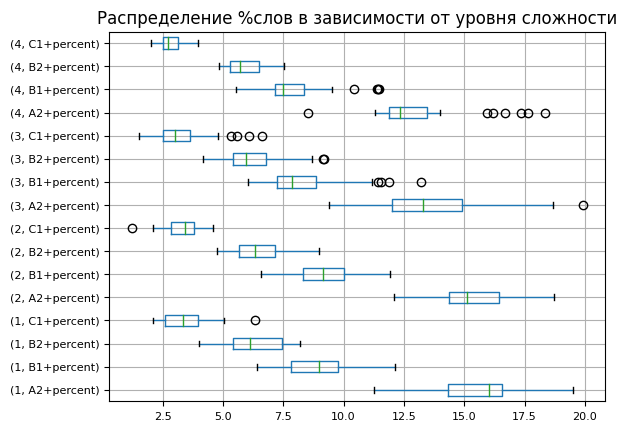

In [28]:
title='Распределение %слов в зависимости от уровня сложности'
ax = X.groupby(y).boxplot(subplots=False,
                     fontsize=8,
                     vert=False,
                     grid =True,
                     )
ax.set_title(title)
plt.show()

Распределение уровня сложности слов почти не зависит от уровня сложности субтитров

##Выбор модели

###Выбор метрики качества
В связи с тем, что:в данных обнаружен дисбаланс классов;
в текущей задаче является важным как точность ('precision') так и полнота ('recall') предсказания модели;
лучшей метрикой для подгонки и оценки модели принимается средне-гармоническое точности и полноты - F1-мера. Для мультиклассификации будет использована взвешенная F1-мера (F1_weighted).

### Создание пайплана

In [29]:
report = pd.DataFrame(columns = ['model',
                                 'classificator',
                                 'vectorizer',
                                 'hparams',
                                 'F1 score'
                                 ])

In [30]:
a2 =  Pipeline([
                ('selector', NumberSelector(key='A2+percent')),
                ('standard', MinMaxScaler())
            ])
b1 =  Pipeline([
                ('selector', NumberSelector(key='B1+percent')),
                ('standard', MinMaxScaler())
            ])
b2 =  Pipeline([
                ('selector', NumberSelector(key='B2+percent')),
                ('standard', MinMaxScaler())
            ])
c1 =  Pipeline([
                ('selector', NumberSelector(key='C1+percent')),
                ('standard', MinMaxScaler())
            ])

In [31]:
vects = [[('vec', CountVectorizer(stop_words='english')),
          {
           'features__text__vec__ngram_range': [(1,2),(2,2),(1,3)],
           'features__text__vec__min_df': [2,3,4]
           }
          ],
         [('vec', TfidfVectorizer(stop_words='english')),
{
           'features__text__vec__ngram_range': [(1,2),(2,2),(1,3)],
           'features__text__vec__min_df': [2,3,4]
           }
          ]]

clfs = [[SGDClassifier(random_state=STATE),
         {'classifier__alpha': [0.001, 0.01, 0.1]}
         ],
          [MultinomialNB(),
           {'classifier__alpha': [0.5, 1]}
         ]]

###Обучение моделей

In [32]:
%%time
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=6,
                                                  test_size=0.25,
                                                  random_state=STATE)
for vec in vects:
  vecpipe = Pipeline([('selector', TextSelector(key='subs')),
                      vec[0]
                      ])
  vecpipe.fit_transform(X)
  featscountvector = FeatureUnion([('text', vecpipe),
                      ('A2+percent', a2),
                      ('B1+percent', b1),
                      ('B2+percent', b2),
                      ('C1+percent', c1),
                        ])

  feature_processing = Pipeline([('feats', featscountvector)])
  feature_processing.fit_transform(X)

  for clf in clfs:
    clfpipeline = Pipeline([
        ('features', featscountvector),
        ('classifier', clf[0]),
    ])
    hyperparameters = vec[1]|clf[1]
    clfpipegridcv = GridSearchCV(clfpipeline,
                                hyperparameters,
                                cv=stratified_shuffle_split,
                                scoring='f1_weighted'
                                )
    clfpipegridcv.fit(X, y)
    report.loc[len(report)]=[clfpipegridcv.best_estimator_,
                             str(clf[0]),
                             str(vec[0]),
                             str(clfpipegridcv.best_params_),
                             clfpipegridcv.best_score_
                             ]
report = report.sort_values(by='F1 score',ascending=False)
report.reset_index(drop= True , inplace= True )
report

CPU times: user 23min 2s, sys: 47.9 s, total: 23min 50s
Wall time: 23min 25s


,model,classificator,vectorizer,hparams,F1 score
0,"(FeatureUnion(transformer_list=[('text',\n ...",MultinomialNB(),"('vec', CountVectorizer(stop_words='english'))","{'classifier__alpha': 1, 'features__text__vec_...",0.698449
1,"(FeatureUnion(transformer_list=[('text',\n ...",SGDClassifier(random_state=0),"('vec', TfidfVectorizer(stop_words='english'))","{'classifier__alpha': 0.001, 'features__text__...",0.657722
2,"(FeatureUnion(transformer_list=[('text',\n ...",SGDClassifier(random_state=0),"('vec', CountVectorizer(stop_words='english'))","{'classifier__alpha': 0.1, 'features__text__ve...",0.631287
3,"(FeatureUnion(transformer_list=[('text',\n ...",MultinomialNB(),"('vec', TfidfVectorizer(stop_words='english'))","{'classifier__alpha': 0.5, 'features__text__ve...",0.333369


In [33]:
#выбираем и обучаем лучшую модель на всем наборе данных
clf = report['model'].loc[0]
clf.fit(X, y)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='subs')),
                                                                 ('vec',
                                                                  CountVectorizer(min_df=3,
                                                                                  ngram_range=(1,
                                                                                               3),
                                                                                  stop_words='english'))])),
                                                ('A2+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='A2+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('B1+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='B1+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('B2+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='B2+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('C1+percent',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='C1+percent')),
                                                                 ('standard',
                                                                  MinMaxScaler())]))])),
                ('classifier', MultinomialNB(alpha=1))])

##Оценка модели на тестовой  выборке

In [34]:
X_test['subs'] = X_test['subs'].apply(clean_subs)
X_test.loc[:,levpercent] = X_test['subs'].apply(count_percent_words_dictionar).to_list()

              precision    recall  f1-score   support

           1       1.00      0.12      0.22         8
           2       0.46      0.79      0.58        14
           3       0.87      0.77      0.82        26
           4       1.00      1.00      1.00        10

    accuracy                           0.72        58
   macro avg       0.83      0.67      0.65        58
weighted avg       0.81      0.72      0.71        58



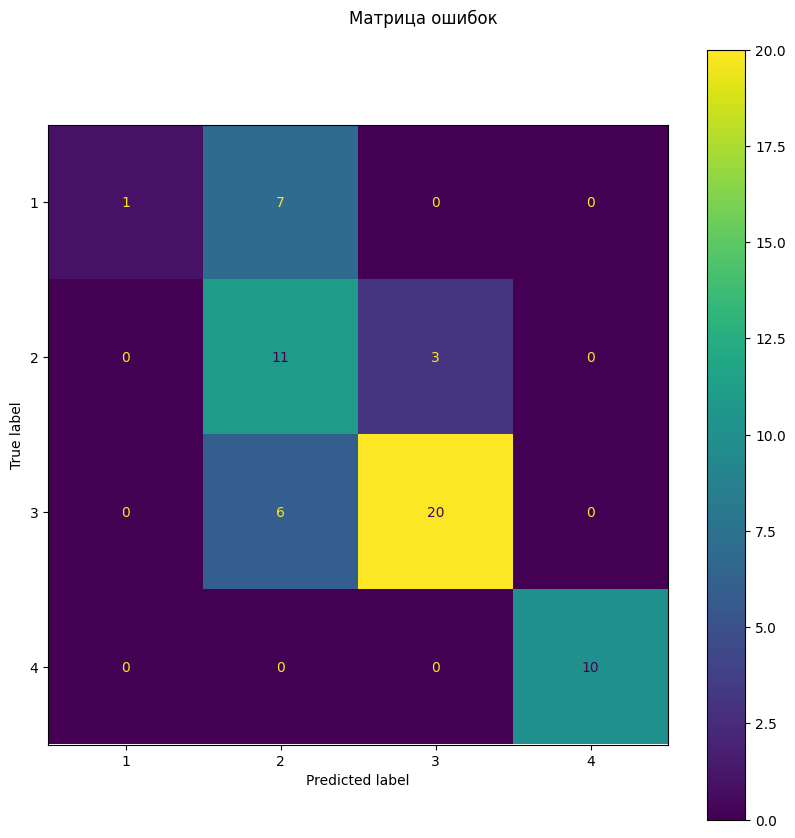

In [35]:
def plot_confusion_matrix(y_test, y_preds, model):
  """строит матрицу ошибок"""
  fig, ax = plt.subplots(figsize=(10,10))
  cm = confusion_matrix(y_test, y_preds)
  cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
  cmp.plot(ax=ax)
  plt.suptitle('Матрица ошибок', y=0.92)
  plt.show()
predictions =clf.predict(X_test)
# выведем классификационную таблицу и матрицу ошибок
print(classification_report(y_test, predictions))
plot_confusion_matrix(y_test, predictions, clf)

###Выводы по результатам работы модели
Из оценки классификатора на тестовой выборке можно сделать следующие выводы:

Модель MultinomialNB() чаще всего ошибается на граничных метках.
Взвешенная метрика F1-weighted на тестовой выборке составила 0.71.

##Выводы
В ходе работы было выполнено:

Загрузка необходимых библиотек;
загрузка и ознакомление с данными (загружены субтитры, фильмы с метками уровня сложности, классический словарь Oxford с 5000 словами);
предобработка данных (очистка от дубликатов, проверка наличия разметки для обучающих данных, определение исходного количества представленных данных, очитска текста субтитров, разбивка на обучающую и тестовую выборки);
Выбора метода препроцессинг данных, а именно преобразование текство субтитров с компактную разреженную матрицу с помощью CountVectorizer,  TfidfVectorizer.
Добавление дополнительных признаков- количество уникальных лемм (слов основной формы), содержащихся в каждом тексте субтитров согласно уровню сложности по классичесокму словарю Oxford;
обоснование использования метрики качества F1-weighted;
Выбор модели-классификатора MultinomialNB, SGDClassifier с побором гиперпараметров. Оценка модели на тестовой выборке.